In [1]:
import pandas as pd
import matplotlib.pyplot as plt

year = 2023

exists_previous_year = False
try:
    pd.read_csv('data/' + str(year - 1) + '.csv')
    exists_previous_year = True
except:
    pass
data_prev = pd.read_csv('data/' + str(year - 1) + '.csv') if exists_previous_year else None    
if data_prev is not None:
    data_prev = data_prev[data_prev['place'] <= 10]
    data_prev['date'] = pd.to_datetime(data_prev['date'], format='%d.%m.%Y')
    data_prev['points'] = 11 - data_prev['place']
    data_prev["name"] = data_prev["firstname"] + " " + data_prev["lastname"]

data = pd.read_csv('data/' + str(year) + '.csv')
data = data[data['place'] <= 10]
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data['points'] = 11 - data['place']
data["name"] = data["firstname"] + " " + data["lastname"]

In [2]:
from IPython.display import display

athletes_per_club = data.groupby('club')['athleteId'].nunique()
athletes_per_club = athletes_per_club.reset_index()
athletes_per_club.columns = ['Verein', 'Athleten']
athletes_per_club = athletes_per_club.sort_values(by='Athleten', ascending=False)

# Filtert Mannschafts und Staffel Ergebnisse heraus, welche nur einmal gewertet werden sollen
clubData = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])
clubData_prev = data_prev.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date']) if exists_previous_year else None

# Punkte pro Verein aggregieren
clubData = clubData.groupby('club')['points'].sum().reset_index()
if clubData_prev is not None:
    clubData_prev = clubData_prev.groupby('club')['points'].sum().reset_index()
    clubData_prev = clubData_prev.rename(columns={'points': 'Punkte', 'club': 'Verein'})

# new 
order = [
    "M",
    "F",
    "MU20",
    "WU20",
    "MU18",
    "WU18",
    "M15",
    "M14",
    "W15",
    "W14",
    "M13",
    "M12",
    "W13",
    "W12",
    "points"
]
club_age_group_data = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])
club_age_group_data = club_age_group_data.groupby(['club', 'ageGroup'])['points'].sum().reset_index()

club_age_group_data_pivot = club_age_group_data.pivot(index='club', columns='ageGroup', values='points')
club_age_group_data_pivot.fillna(0, inplace=True)
club_age_group_data_pivot.reset_index(inplace=True)
clubData = clubData.merge(club_age_group_data_pivot, on='club', how='left')

for age_group in order:
    clubData[age_group] = clubData[age_group].astype(int)
    
clubData = clubData[['club'] + order]


# Vereine nach Punkten sortieren und Index zurücksetzen
clubData = clubData.sort_values(by='points', ascending=False)
clubData = clubData.reset_index(drop=True)
clubData = clubData.rename(columns={'points': 'Punkte'})
clubData.index += 1

combined_data = pd.merge(athletes_per_club, clubData, left_on='Verein', right_on='club', how='outer')
combined_data.drop(columns='club', inplace=True)
combined_data['Verhältnis Punkte/Athleten'] = round(combined_data['Punkte'] / combined_data['Athleten'], 2)
combined_data = combined_data.sort_values(by='Punkte', ascending=False)
combined_data.reset_index(drop=True, inplace=True)
combined_data.index += 1

if clubData_prev is not None:
    combined_data = combined_data.merge(clubData_prev, on='Verein', how='left')
    combined_data['Differenz ' + str(year - 1) + '/' + str(year)] = combined_data['Punkte_x'] - combined_data['Punkte_y']
    combined_data.rename(columns={'Punkte_x': 'Punkte ' + str(year), 'Punkte_y': 'Punkte ' + str(year - 1)}, inplace=True)
    # fill NaN values for Punkte year -1 with -1
    combined_data['Punkte ' + str(year - 1)].fillna(0, inplace=True)
    combined_data['Differenz ' + str(year - 1) + '/' + str(year)].fillna(0, inplace=True)
    combined_data['Differenz ' + str(year - 1) + '/' + str(year)] = combined_data['Differenz ' + str(year - 1) + '/' + str(year)].astype(int)
    combined_data['Punkte ' + str(year - 1)] = combined_data['Punkte ' + str(year - 1)].astype(int)


cols = list(combined_data.columns)
cols.remove('Athleten')
cols.remove('Verhältnis Punkte/Athleten')
cols.append('Athleten')
cols.append('Verhältnis Punkte/Athleten')
combined_data = combined_data[cols]


display(combined_data)

,Verein,M,F,MU20,WU20,MU18,WU18,M15,M14,W15,W14,M13,M12,W13,W12,Punkte 2023,Punkte 2022,Differenz 2022/2023,Athleten,Verhältnis Punkte/Athleten
0,LC Rehlingen,443,337,151,151,300,137,203,193,145,378,224,136,229,214,3241,3468,-227,152,21.32
1,LA Team Saar,103,212,59,30,229,40,164,47,384,270,203,154,252,60,2207,2243,-36,113,19.53
2,SV GO! Saar 05,178,268,37,93,58,79,432,133,74,0,15,41,69,73,1550,1062,488,61,25.41
3,LSG Sbr.-Sulzbachtal,181,59,240,163,112,73,22,143,18,82,30,110,82,18,1333,1358,-25,71,18.77
4,LG Saar 70,0,9,32,64,0,34,202,41,49,24,78,27,138,50,748,771,-23,58,12.90
5,ATSV Saarbrücken,45,5,72,104,46,50,0,55,59,91,127,0,9,60,723,736,-13,35,20.66
6,LG Berus,23,219,0,54,26,0,21,0,148,8,131,75,6,0,711,563,148,23,30.91
7,TV St. Wendel,8,0,25,18,135,190,0,0,37,18,0,72,1,53,557,314,243,18,30.94
8,LAC Saarlouis,22,68,0,72,14,31,158,0,55,0,64,12,34,10,540,502,38,26,20.77
9,LV Merzig,14,20,25,0,57,137,68,0,35,56,0,58,0,46,516,485,31,22,23.45


C:\Users\NIKLAS~1\AppData\Local\Temp/ipykernel_14340/3396393972.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  birthYearData = data.groupby(['birthyear', 'gender'])['points'].sum().reset_index()


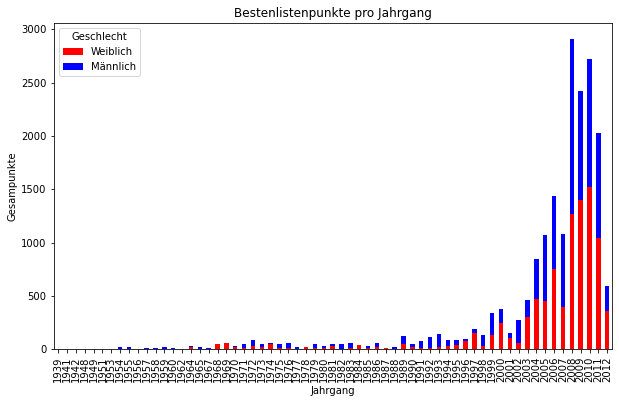

gender,Weiblich,Männlich
birthyear,,
2012,363,227
2011,1042,986
2010,1520,1203
2009,1403,1019
2008,1271,1641
2007,392,685
2006,751,685
2005,455,615
2004,473,376


In [3]:


data['gender'] = data['ageGroup'].apply(lambda x: "Männlich" if 'M' in x else "Weiblich")
data['gender'] = pd.Categorical(data['gender'], categories=["Weiblich", "Männlich"])

# Punkte pro Jahrgang und Geschlecht aggregieren
birthYearData = data.groupby(['birthyear', 'gender'])['points'].sum().reset_index()
birthYearData = birthYearData[birthYearData['birthyear'] != 0]

pivot_data = birthYearData.pivot_table(index='birthyear', columns='gender', values='points', aggfunc='sum', fill_value=0)
colors = {'Männlich': 'blue', 'Weiblich': 'red'}
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in pivot_data.columns])
plt.title('Bestenlistenpunkte pro Jahrgang')
plt.xlabel('Jahrgang')
plt.ylabel('Gesampunkte')
plt.legend(title='Geschlecht', loc='upper left')
plt.show()

display(pivot_data.sort_values(by='birthyear', ascending=False).head(20))

## Anzahl Athleten pro Jahrgang in Bestenliste Top 10

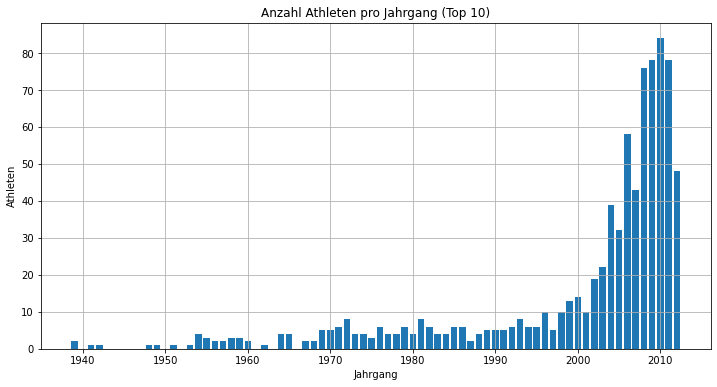

,Jahrgang,Athleten
1,2012,48
2,2011,78
3,2010,84
4,2009,78
5,2008,76
6,2007,43
7,2006,58
8,2005,32
9,2004,39
10,2003,22


In [4]:
## amount of athletes per birthyear
birthyear_counts = data[data['birthyear'] != 0]
birthyear_counts = birthyear_counts.drop_duplicates(subset=['name', 'birthyear'])
birthyear_counts = birthyear_counts['birthyear'].value_counts().reset_index()
birthyear_counts.columns = ['Jahrgang', 'Athleten']
birthyear_counts = birthyear_counts.sort_values(by='Jahrgang', ascending=False)
# plot data
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(birthyear_counts['Jahrgang'], birthyear_counts['Athleten'])
ax.set_xlabel('Jahrgang')
ax.set_ylabel('Athleten')
ax.set_title('Anzahl Athleten pro Jahrgang (Top 10)')
plt.grid()
plt.show()  

birthyear_counts.reset_index(drop=True, inplace=True)
birthyear_counts.index += 1
display(birthyear_counts.head(25))

In [5]:
rankedData = data.groupby(['club', 'name'])['points'].sum().reset_index()

rankedData = rankedData.sort_values(by='points', ascending=False)
rankedData = rankedData.reset_index(drop=True)
rankedData = rankedData.rename(columns={'club': 'Verein', 'points': 'Punkte', 'name': 'Name'})
rankedData.index += 1

display(rankedData.head(20))

,Verein,Name,Punkte
1,LC Rehlingen,Jonas Hoffmann,153
2,SV GO! Saar 05,Tim Jungmann,148
3,SV GO! Saar 05,Jonas Fahrig,147
4,LSG Sbr.-Sulzbachtal,Niels Jung,141
5,LA Team Saar,Lilianne Weis,140
6,LC Rehlingen,Liara Schulze,140
7,LC Rehlingen,Mathilda Klein,136
8,SV GO! Saar 05,Manuel Bernabeu Walz,132
9,LG Berus,Sina Vervin,121
10,LAC Saarlouis,Santiago Kalkes,121


## Anzahl der Bestenlistenpunkte pro Ort

In [6]:
top_10_point_locations = data.drop_duplicates(subset=['ageGroup', 'club', 'discipline', 'result', 'teamResult', 'place', 'location', 'date'])
top_10_point_locations = top_10_point_locations.groupby('location')['points'].sum().reset_index()
top_10_point_locations = top_10_point_locations.sort_values(by='points', ascending=False)
top_10_point_locations = top_10_point_locations.reset_index(drop=True)
top_10_point_locations = top_10_point_locations.rename(columns={'location': 'Ort', 'points': 'Punkte'})
top_10_point_locations.index += 1
display(top_10_point_locations.head(10))

,Ort,Punkte
1,Püttlingen,5348
2,Rehlingen,1748
3,Saarbrücken,1276
4,Saarlouis,1042
5,Friedrichsthal,599
6,Überherrn,583
7,Dillingen,404
8,Ottweiler,401
9,St. Wendel,370
10,Lebach,309


## Durchschnittliches Alter in der Aktivenklassen

In [7]:
age_data = data[data['birthyear'] != 0]
male_data = age_data[age_data['ageGroup'] == 'M']
female_data = age_data[age_data['ageGroup'] == 'F']
avg_birth_year_male  = year - round(male_data['birthyear'].mean());
avg_birth_year_female = year - round(female_data['birthyear'].mean());

print("Durchschnittliches Alter in der Männer Klasse :", avg_birth_year_male)
print("Durchschnittliches Alter in der Frauen Klasse :", avg_birth_year_female)

Durchschnittliches Alter in der Männer Klasse : 34
Durchschnittliches Alter in der Frauen Klasse : 31


## Älteste Athleten

In [8]:
oldest_entries = data[data['birthyear'] != 0]
oldest_entries = oldest_entries.groupby(['name', 'birthyear', 'club', 'ageGroup']).size().reset_index(name='count')
oldest_entries = oldest_entries.sort_values(by='birthyear', ascending=True)
oldest_entries.columns = ['Name', 'Geburtsjahr', 'Verein', 'Altersklasse', 'Nennungen']
oldest_entries['Alter'] = year - oldest_entries['Geburtsjahr']
oldest_entries.reset_index(drop=True, inplace=True)
oldest_entries.index += 1
display(oldest_entries.head(10))

,Name,Geburtsjahr,Verein,Altersklasse,Nennungen,Alter
1,A. Buchholz,1939,StG GO! Saar Express,M,1,84
2,Horst Backes,1939,StG GO! Saar Express,M,1,84
3,I. Kroker,1941,StG GO! Saar Express,M,1,82
4,R. Bindel,1942,StG GO! Saar Express,M,1,81
5,Margot Junk,1948,SC Friedrichsthal,F,1,75
6,Inge Weisenstein,1949,SC Friedrichsthal,F,1,74
7,Monika Schuh,1951,LLG Wustweiler,F,1,72
8,Ortwin Krebs,1953,LA Team Saar,M,1,70
9,Margit Müller,1954,LLG Wustweiler,F,1,69
10,Jörg Dietrich,1954,LC Rehlingen,M,2,69
